In [2]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 70.4 MB/s 
     |████████████████████████████████| 7.6 MB 41.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 115 kB 62.8 MB/s 
     |████████████████████████████████| 212 kB 54.5 MB/s 
     |████████████████████████████████| 127 kB 67.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import json
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
DATA_PATH = '/content/drive/MyDrive/Limbo/nlp-project/data'
BILLSUM_DATA_PATH = os.path.join(DATA_PATH, 'billsum_v4_1')

In [12]:
def read_jsonl_file(FILE_PATH):
    X, y = [], []
    text_len, summary_len = [], []
    with open(FILE_PATH, 'r') as jsonfile:
        for line in jsonfile.readlines():
            json_obj = json.loads(line)
            X.append(json_obj['text'])
            y.append(json_obj['summary'])
            text_len.append(len(sent_tokenize(json_obj['text'])))
            summary_len.append(len(sent_tokenize(json_obj['summary'])))

    return X, y, text_len, summary_len

In [13]:
X_train, y_train, text_train_len, sum_train_len = read_jsonl_file(os.path.join(BILLSUM_DATA_PATH, 'us_train_data_final_OFFICIAL.jsonl'))

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [15]:
tokenizer = AutoTokenizer.from_pretrained("philippelaban/keep_it_simple")
kis_model = AutoModelForCausalLM.from_pretrained("philippelaban/keep_it_simple")

Downloading:   0%|          | 0.00/243 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/108 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/893 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [16]:
print(y_train[0])

Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for the costs associated with providing emergency medical and ambulance services in Arizona to: (1) illegal aliens who are not detained by any Federal, State, or local law enforcement authority. Or (2) aliens paroled into the United States for less than one year to receive emergency medical treatment.


In [17]:
paragraph = y_train[0]

start_id = tokenizer.bos_token_id
tokenized_paragraph = [(tokenizer.encode(text=paragraph) + [start_id])]
input_ids = torch.LongTensor(tokenized_paragraph)

output_ids = kis_model.generate(input_ids, max_length=600, num_beams=4, do_sample=True, num_return_sequences=8)
output_ids = output_ids[:, input_ids.shape[1]:]
output = tokenizer.batch_decode(output_ids)
output = [o.replace(tokenizer.eos_token, "") for o in output]

for o in output:
    print("----")
    print(o)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal aliens who are not currently working in the country. Or, as in Arizona, aliens who have been paroled into the United States for less than one year will receive free health care.
----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal immigrants who are not currently working in the country. Or, as in Arizona, aliens who are not detained by any law enforcement agency will receive free health care.
----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-

# FKGL Score Evaluation
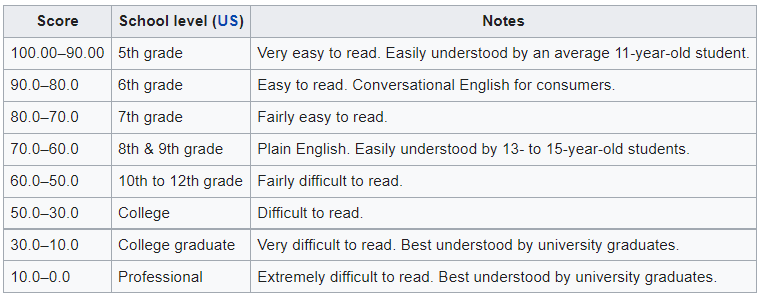

In [18]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 38.0 MB/s 


In [19]:
import spacy
from textstat import syllable_count

In [20]:
def break_sentences(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    return list(doc.sents)

def word_count(text):
    sentences = break_sentences(text)
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words

def sentence_count(text):
    sentences = break_sentences(text)
    return len(sentences)

def syllables_count(word):
    return syllable_count(word)

In [21]:
def flesh_reading_ease(text):
  word_freq = word_count(text) / sentence_count(text)
  syllable_freq = syllable_count(text) / word_count(text)

  return 206.835 - (1.015 * word_freq) - (84.6 * syllable_freq)

In [22]:
text = "Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal immigrants who are not currently working in the country. Or, as in Arizona, aliens paroled into the United States for up to one year to receive emergency medical care."
flesh_reading_ease(text)

49.270000000000024

In [30]:
print(flesh_reading_ease(y_train[0]))
print(output[-1])
for elem in output:
  print(elem)
  print(flesh_reading_ease(elem))

35.83000000000001
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal aliens who are not in need of medical care but who wish to work in Arizona for free.
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal aliens who are not currently working in the country. Or, as in Arizona, aliens who have been paroled into the United States for less than one year will receive free health care.
55.972500000000025
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement f

In [ ]:
for i in range(len(y_train)):
  paragraph = y_train[i]

  start_id = tokenizer.bos_token_id
  tokenized_paragraph = [(tokenizer.encode(text=paragraph) + [start_id])]
  input_ids = torch.LongTensor(tokenized_paragraph)

  output_ids = kis_model.generate(input_ids, max_length=600, num_beams=4, do_sample=True, num_return_sequences=4)
  output_ids = output_ids[:, input_ids.shape[1]:]
  output = tokenizer.batch_decode(output_ids)
  output = [o.replace(tokenizer.eos_token, "") for o in output]
  print(i)
  for o in output:
      print("----")
      print(o)
      print(flesh_reading_ease(o))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


0
----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal aliens who are not currently working in the country. Or, as in Arizona, aliens paroled into the United States for up to one year to receive medical care.
54.03066901408452
----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for illegal aliens who are not currently detained by any government agency. Or, as in Arizona, aliens who are not in need of emergency medical care will be allowed to stay in the United States for up to one year.
49.79416666666668
----
Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


49.270000000000024
1
----
Farm to School improvements act of 2010 - which amends the Richard B. Russell National School Lunch Act to direct the secretary of agriculture to provide competitive grants to schools, nonprofit organizations, and other able entities for lunch and breakfast programs that improve access to healthy food and healthy lifestyle choices for children. Provides that each grant may include matching grants for school staff and volunteers, training and technical assistance grants, and planning grants.
45.68000000000002
----
Farm to School improvements act of 2010 - which amends the Richard B. Russell National School Lunch Act to direct the Secretary of Agriculture to provide competitive grants to schools, nonprofit organizations, and other able entities for lunch and breakfast programs that improve access to healthy food and healthy lifestyle choices for children. Provides that each grant may include an implementation grant, training and technical assistance grant, and p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


47.88876811594204
2
----
Persian Gulf War illness compensation act of 2001 - which provides for compensation for disabilities arising in veterans of the Persian Gulf War - is amended to require compensation for undiagnosed illnesses, to be compensable before December 31, 2011, or as prescribed by the Secretary of Veterans Affairs.
19.020384615384614
----
Persian Gulf War illness compensation act of 2001 - which provides for compensation for disabilities occurring in veterans of the Persian Gulf War - is amended to require compensation for undiagnosed conditions in veterans of the same conflict to occur by December 31, 2011.
22.210217391304383
----
Persian Gulf War illness compensation act of 2001 - which provides for compensation for disabilities arising in veterans of the Persian Gulf War - is amended to require compensation for undiagnosed conditions, to be compensable, or at a later date as prescribed by the Secretary of Veterans Affairs.
20.7052941176471
----
Persian Gulf War illne

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


19.020384615384614
3
----
Medicare Part D is designed to provide additional funding for area health insurance counseling and assistance programs for beneficiaries who are already enrolled in Medicare. It makes appropriations to the Centers for Medicare to fund additional grants to state health insurance counseling and assistance programs to combat the growing number of people on Medicare who do not have access to health insurance (HICA) and other services (SSA).
36.513527397260304
----
Medicare Part D is intended to provide additional funding to the Centers for Medicare Medicaid Services to conduct outreach and education related to enrollment in the Medicare program. It also makes appropriations to areas for which state health insurance counseling and assistance is needed, such as on Aging and Native American health care, to conduct outreach and education related to the Medicare program.
30.14891791044778
----
Medicare Part D is designed to provide additional funding to the Centers for

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


45.74111111111114
4
----
Seniors' retirement recovery act of 2002 - which makes it clear that the 1993 income tax increase on Social Security benefits will not be repealed - is appropriate from the general fund, to the Hospital Insurance Trust. Increases the age at which pension and retirement distributions must start from 70 12.
55.867954545454566
----
Seniors' retirement recovery act of 2002 - which makes it clear that the 1993 income tax increase on Social Security benefits will not be repealed - is not retroactive. Appropriates, from the general fund, to the Hospital Insurance Trust, amounts equal to the revenue loss from the 1993 income tax increase.
65.10750000000002
----
Seniors' retirement recovery act of 2002 - which replaces the 1993 income tax increase on Social Security benefits - does not change the Internal Revenue Code. Appropriates, from the general fund, to the Hospital Insurance Trust, amounts equal to the revenue loss from the 1993 income tax increase.
61.93000000000

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


63.306538461538494
5
----
Improved Health Care at Lower Cost Act of 2013 - Amends the title XVIII (Medicare) and XI of the Social Security Act with respect to the prohibition against physician referrals. Excepts from this provision any monetary incentive payments made by hospitals to physicians under certain incentive payment programs designed to align incentives among hospitals and physicians to improve efficiency and reduce costs while maintaining or improving quality.
32.58278169014085
----
Improved health care at lower cost in 2013 - Amends the title XVIII (Medicare) and XI of the Social Security Act with respect to the prohibition against physician referrals. Excepts from this provision any monetary incentive payments made by hospitals to physicians must be in line with their stated goal of improving efficiency and reducing costs while maintaining or improving quality.
42.39211538461541
----
Improved health care at lower cost is part of the act of 2013. Amends the Social Security 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


41.09057692307695
6
----
Making Access Records available to lead the American Government openness act or the MAR-A-LAGO, this bill directs the President to establish and update, every 90 days, a publicly available database of records of visitors at the White House, residence of the Vice-President, or any other location at which the President or Vice-President regularly conducts official business. The list of visitors, including the names of each, shall be made available to the public.
47.60008426966294
----
Making Access Records available to lead the American Government openness act or the MAR-A-LAGO, this bill directs the President to establish and update, every 90 days, a publicly available database of records of visitors at the White House, residence of the Vice-President, or any other place where the President or Vice-President regularly conducts official business. The list of visitors must also include the names of all other people who have visited the White House in the past year

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


53.01325581395349
